In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(666)

In [2]:
def prettifyDurationInSeconds(pDurationInSeconds):
    seconds = pDurationInSeconds % 60
    durationInMinutes = (pDurationInSeconds - seconds) // 60
    minutes = durationInMinutes % 60
    hours = (durationInMinutes - minutes) // 60

    return f"{hours}h {minutes}m {seconds}s"

In [3]:
def arange(start, end, step):
    return np.linspace(start, end, int(np.ceil((end - start) / step) + 1))

In [4]:
def soft_threshold(a, b):
    return np.sign(a) * np.maximum(np.abs(a) - b, 0)

In [5]:
def solve(breakpoints, penalties, bias):
    breakpoints = [float("-inf")] + breakpoints + [float("+inf")]
    minus_sum = 0
    plus_sum = sum(penalties)

    for i in range(len(breakpoints) - 1):        
        v = bias - minus_sum + plus_sum

        if breakpoints[i] < v <= breakpoints[i + 1]:
            return v

        if i == len(breakpoints) - 2:
            break

        minus_sum += penalties[i]
        plus_sum -= penalties[i]

    return None

In [6]:
class FLSA_2D:
    __slots__ = ['__lambda_1', '__lambda_2', '__max_iter', '__tol', 'n1', 'n2', 'G', 'neighbours', 'y_bar', 'N', 'gamma']
    
    @property
    def coef_(self):
        # initiate matrix of sizes of original data matrix y
        r = np.zeros((self.n1, self.n2))
        # iterate over every found group
        for k in range(len(self.G)):
            # iterate over every point that belongs to that group
            for p in self.G[k]:
                # set value of pixel at point p to value of gamma of that group
                r[p[0], p[1]] = self.gamma[k]
        # return result
        return r
        
    def __init__(self, lambda_1=1.0, lambda_2=1.0, max_iter=1000, tol=0.0001):
        self.__lambda_1 = lambda_1
        self.__lambda_2 = lambda_2
        self.__max_iter = max_iter
        self.__tol = tol
        
        return

    def loss(self, gamma):
        s = 0
        for k in range(len(gamma)):
            s += (np.array(list(self.neighbours[k].values())) * abs(gamma[k] - gamma[list(self.neighbours[k].keys())])).sum()
                    
        return 0.5 * (self.N * (self.y_bar - gamma) ** 2).sum() + self.__lambda_1 * (self.N * abs(gamma)).sum() + self.__lambda_2 / 2 * s

    def roughly_equal(self, a, b):
        return np.linalg.norm(a - b, 2) < self.__tol

    def fit(self, y, quick=True):
        # set increment for lambda_2
        delta = 1e-9
        # read shape of incoming data
        self.n1, self.n2 = y.shape
        # function to check whether point p=(i, j) is in bounds of data matrix y
        def in_bounds(i, j):
            return 0 <= i < self.n1 and 0 <= j < self.n2
        # initiate set of groups — every pixel is its own group at the beginning
        self.G = [[(i, j)] for i in range(self.n1) for j in range(self.n2)]
        # set of neighbours
        # self.neighbours[k] is a dict of neighbours of k-th group 
        # where keys correspond to indexes of groups of these neighbours
        # and values to length of shared border between group k and this neighbour
        # at the beginning every pixel has either 2, 3 or 4 neighbours
        self.neighbours = []
        for i in range(self.n1):
            for j in range(self.n2):
                # initiate list of neighbours
                self.neighbours.append({})
                # if there is neighbour above
                if in_bounds(i - 1, j):
                    # add it with shared border length 1
                    self.neighbours[-1][(i - 1) * self.n1 + j] = 1
                # if there is neighbour below
                if in_bounds(i + 1, j):
                    # add it with shared border length 1
                    self.neighbours[-1][(i + 1) * self.n1 + j] = 1
                # if there is neighbour to the left
                if in_bounds(i, j - 1):
                    # add it with shared border length 1
                    self.neighbours[-1][i * self.n1 + j - 1] = 1
                # if there is neighbour to the right
                if in_bounds(i, j + 1):
                    # add it with shared border length 1
                    self.neighbours[-1][i * self.n1 + j + 1] = 1
        # average value of data at every group
        # since every group as of now consists of only one pixel it has exactly data matrix y values
        self.y_bar = y.flatten()
        # sizes of groups, i.e. 1 for every group
        self.N = np.ones(y.shape, dtype=np.int32).flatten()
        # initial values of gamma
        gamma = soft_threshold(self.y_bar, self.__lambda_1)
        # smooth cycle
        # for quicker computations there is available option of using static number of iterations — 1000
        # if to be precies as in paper, second option allows to increment values from 0 to lambda_2 by ~delta
        for lambda_2 in (np.linspace(delta, self.__lambda_2, 10) if quick else arange(delta, self.__lambda_2, delta)):
            # retry cycles until converged
            converged = False
            for _ in range(self.__max_iter):
                # copy current value of gamma so to compare if there was an successful update
                current_gamma = gamma.copy()
                # iterate over every coordinate
                for k in range(len(self.G)):
                    # descent part — try to minimise only in gamma[k] direction
                    # derivative is piece-wise linear at breakpoints
                    breakpoints = np.concatenate(([0], gamma[list(self.neighbours[k].keys())]))
                    # with scaling parameters stored in penalties
                    penalties = np.concatenate(([self.__lambda_1], lambda_2 * np.array(list(self.neighbours[k].values())) / self.N[k]))
                    # we need to sort by breakpoints
                    s = np.argsort(breakpoints)
                    breakpoints = breakpoints[s]
                    penalties = penalties[s]
                    # and since it is piece-wise linear, solution is unique if exists
                    r = solve(breakpoints.tolist(), penalties.tolist(), self.y_bar[k])
                    # copy current value of gamma to compare if update with found solution for gamma[k] is better than before
                    gamma_tmp = gamma.copy()
                    # if there is no solution (0 falls in one of the breaks)
                    if r is None:                        
                        min_v = float("+inf")
                        # we check what value gives loss function with gamma[k] set to breakpoint
                        # and select such value that gives the smallest value of loss
                        for _breakpoint in breakpoints:
                            gamma_tmp[k] = _breakpoint
                            # evaluate
                            v = self.loss(gamma_tmp)
                            if v < min_v:
                                min_v = v
                                r = _breakpoint
                    # so we substitute to check if such an update is good
                    gamma_tmp[k] = r
                    # if it is better
                    if self.loss(gamma_tmp) < self.loss(gamma):
                        # then use this value
                        gamma = gamma_tmp
                        # and continue to the next coordinate
                        continue
                    # if there was no successful one-parameter-at-a-time update we consider fusion part
                    # iterate over every neighbouring group of k-th group and consider fusion
                    for k_prime in self.neighbours[k].keys():
                        # simulate size of potential group
                        N_m = self.N[k] + self.N[k_prime]
                        # simulate average data value at potential group
                        y_bar_m = (self.N[k] * self.y_bar[k] + self.N[k_prime] * self.y_bar[k_prime]) / N_m
                        # evaluate neighbours of potential group
                        neighbours_m = {idx: (0 if not idx in self.neighbours[k].keys() else self.neighbours[k][idx]) + (0 if not idx in self.neighbours[k_prime].keys() else self.neighbours[k_prime][idx]) for idx in set(list(self.neighbours[k].keys()) + list(self.neighbours[k_prime].keys())) if idx != k and idx != k_prime}
                        # apply descent at the direction of fused coordinate
                        # derivative is piece-wise linear at breakpoints
                        breakpoints = np.concatenate(([0], gamma[list(neighbours_m.keys())]))
                        # with scaling parameters stored in penalties
                        penalties = np.concatenate(([self.__lambda_1], lambda_2 * np.array(list(neighbours_m.values())) / N_m))
                        # we need to sort by breakpoints
                        s = np.argsort(breakpoints)
                        breakpoints = breakpoints[s]
                        penalties = penalties[s]
                        # and since it is piece-wise linear, solution is unique if exists
                        r = solve(breakpoints.tolist(), penalties.tolist(), y_bar_m)
                        # copy current value of gamma to compare if update with found solution for gamma[k] is better than before                    
                        gamma_tmp = gamma.copy()
                        # if there is no solution (0 falls in one of the breaks)
                        if r is None:
                            min_v = float("+inf")
                            # we check what value gives loss function with gamma[k] and gamma[k_prime] set to breakpoint
                            # and select such value that gives the smallest value of loss
                            for _breakpoint in breakpoints:
                                gamma_tmp[k] = _breakpoint
                                gamma_tmp[k_prime] = _breakpoint
                                # evaluate
                                v = self.loss(gamma_tmp)
                                if v < min_v:
                                    min_v = v
                                    r = _breakpoint
                        # so we substitute to check if such an update is good
                        gamma_tmp[k] = r
                        gamma_tmp[k_prime] = r
                        # if it is better
                        if self.loss(gamma_tmp) < self.loss(gamma):
                            # then use this value
                            gamma = gamma_tmp
                            # and continue to the next coordinate
                            continue
                # when previous value of gammma is not substantially different from newly acquired one
                if np.linalg.norm(current_gamma - gamma, 2) < self.__tol:
                    # then we found solution for given lambda_2
                    converged = True
                    break
            # show log, if algorithm did not converge
            if not converged:
                print("algorithm did not converge")
            # now time to fuse groups close to each other
            k = 0
            # iterate over every group
            while k < len(self.G):
                # get indexes of neighbours of current k-th group
                neighbours_k_indexes = self.neighbours[k].keys()
                # store indexes of neighbours which are to be fused
                indexes_of_groups_to_fuse = []
                # iterate over every neighbour
                for k_prime in neighbours_k_indexes:
                    # if calculated values of gamma for group k and respective neighbour are close enough and non-zero
                    if self.roughly_equal(gamma[[k]], gamma[[k_prime]]) and not self.roughly_equal(gamma[[k]], 0):
                        # then we want to fuse these two together
                        indexes_of_groups_to_fuse.append(k_prime)
                        # we fuse neighbour into k-th group!
                        # update groups — union of points
                        self.G[k].extend(self.G[k_prime])
                        # update sizes of groups
                        self.N[k] += self.N[k_prime]
                        # update average values of data of groups
                        self.y_bar[k] = (self.y_bar[k] * (self.N[k] - self.N[k_prime]) + self.y_bar[k_prime] * self.N[k_prime]) / self.N[k]
                        # recalculate neighbours for new group:
                        # iterate over union of neighbours of k-th group and neighbour-to-be-fused group excluding these groups themselves
                        # calculate new shared borders lengths
                        self.neighbours[k] = {idx: (0 if idx not in self.neighbours[k].keys() else self.neighbours[k][idx]) + (0 if idx not in self.neighbours[k_prime].keys() else self.neighbours[k_prime][idx]) for idx in set(list(self.neighbours[k].keys()) + list(self.neighbours[k_prime].keys())) if idx != k and idx != k_prime}
                        # update such values for neighbours too
                        for key, value in self.neighbours[k].items():
                            # remove the neighbouring relationship with group-to-be-fused since it will get deleted
                            if k_prime in self.neighbours[key].keys():
                                del self.neighbours[key][k_prime]
                            # update shared border length on the new neighbour side
                            self.neighbours[key][k] = value
                # help function to calculate how indexes shift when items are deleted
                def _help(key, remo):
                    i = 0
                    for el in remo:
                        if key > el:
                            i += 1
                    return key - i
                # since we delete some groups their indexes in self.G get shifted (example: deleting 7th group
                # makes group with index 10 to now have index 9, but group with index 0 retains that value)
                # here is the dictionary that maps old indexes to new ones. Why? Because even though we delete entries in self.neighbours
                # and self.G other entries in self.neighbours are still relying on old indexes, so we need to update that values.
                # we use that map-dictionary to do that.
                _map = {key: _help(key, indexes_of_groups_to_fuse) for key in range(len(self.G)) if key not in indexes_of_groups_to_fuse}
                # remove fused groups
                self.G = [el for i, el in enumerate(self.G) if i not in indexes_of_groups_to_fuse]
                # remove sizes of fused groups
                self.N = np.delete(self.N, indexes_of_groups_to_fuse)
                # remove average data values of fused groups
                self.y_bar = np.delete(self.y_bar, indexes_of_groups_to_fuse)
                # update referencing indexes and remove neighbouring sets of fused groups
                self.neighbours = [{_map[item]: value for item, value in el.items()} for i, el in enumerate(self.neighbours) if i not in indexes_of_groups_to_fuse]
                # remove gamma values of fused groups
                gamma = np.delete(gamma, indexes_of_groups_to_fuse)
                # continue to the next unfused group
                k += 1
        # save found gamma value
        self.gamma = gamma.copy()
        # return estimator
        return self

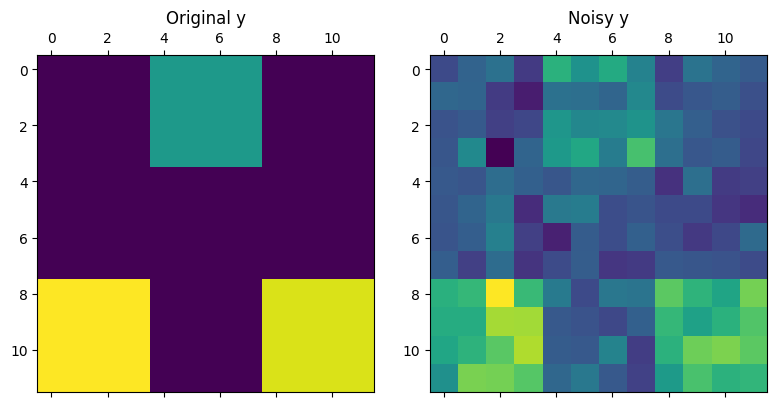

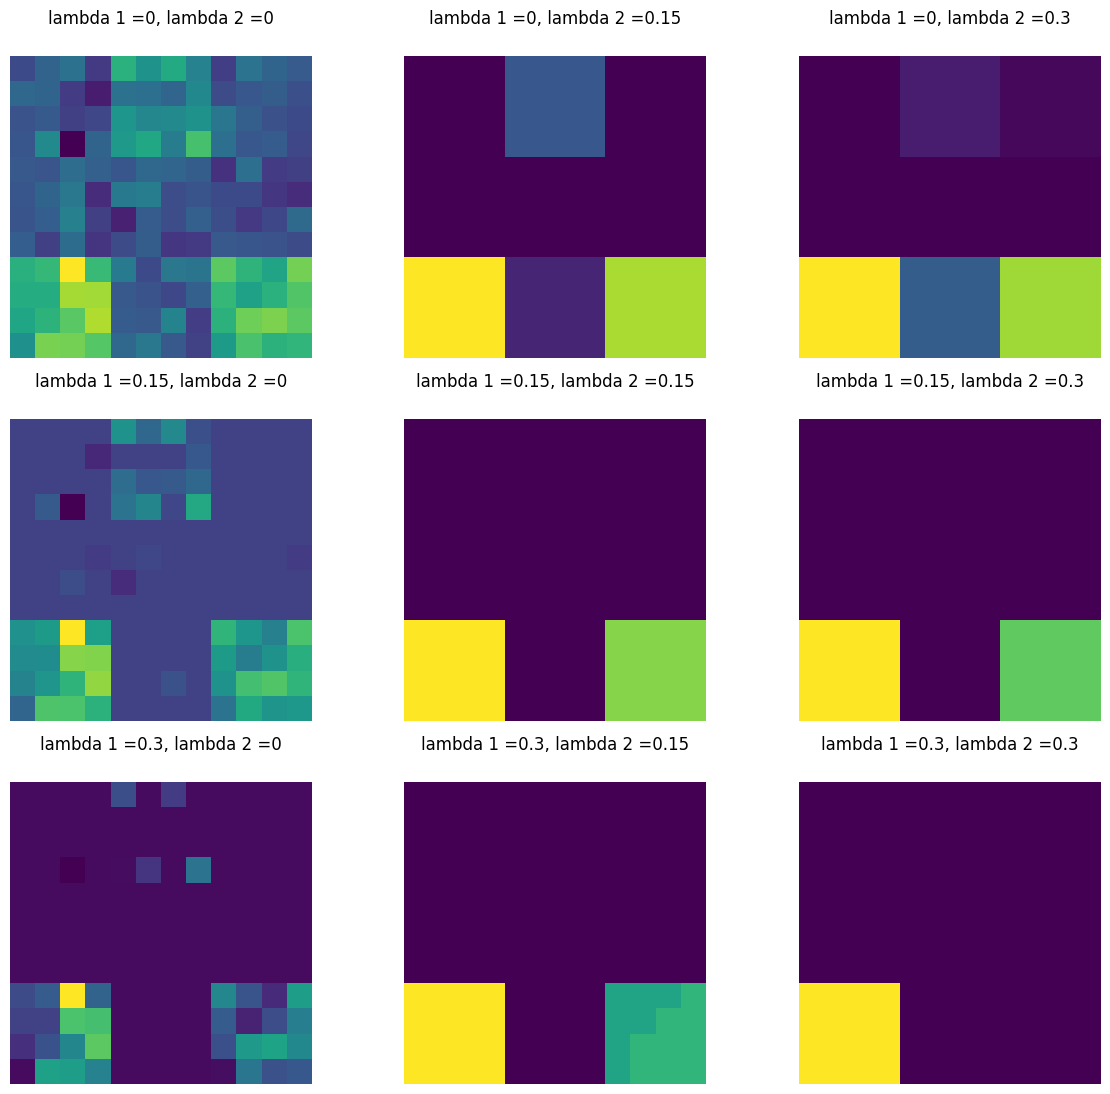

In [ ]:
np.random.seed(12)

o_dim = 3
scale = 4
lambda_vals = [0, 0.15, 0.3]

y_original = np.random.binomial(1, 0.3, o_dim * o_dim).reshape(o_dim, o_dim) * \
             np.random.uniform(0, 1, (o_dim, o_dim)).round(2)
y_original = y_original.repeat(scale, axis=0).repeat(scale, axis=1)
y = y_original + np.random.normal(0, 0.1, y_original.shape)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax[0].matshow(y_original)
ax[0].set_title("Original y")
ax[1].matshow(y)
ax[1].set_title("Noisy y")
plt.tight_layout()
plt.savefig("images/original_and_noisy_comparison_1.png")
plt.show()

fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i, lambda_1 in enumerate(lambda_vals):
    for j, lambda_2 in enumerate(lambda_vals):
        model = FLSA_2D(lambda_1=lambda_1, lambda_2=lambda_2, max_iter=10).fit(y)
        ax = axs[i, j]
        ax.matshow(model.coef_)
        ax.set_title(f"lambda 1 ={lambda_1}, lambda 2 ={lambda_2}")
        ax.axis('off')

# plt.suptitle("Denoised outputs for varying lambdas", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("images/denoising_lambda_comparison_1.png")
plt.show()

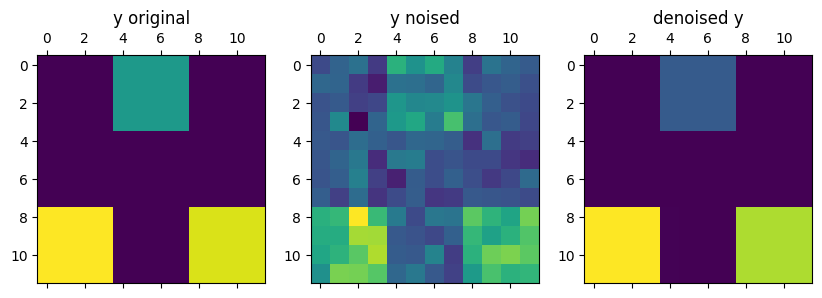

In [ ]:
np.random.seed(12)

o_dim = 3
scale = 4

y_original = np.random.binomial(1, 0.3, o_dim * o_dim).reshape(o_dim, o_dim) * np.random.uniform(0, 1, (o_dim, o_dim)).round(2)
y_original = y_original.repeat(scale, axis=0).repeat(scale, axis=1)
y = y_original + np.random.normal(0, 0.1, y_original.shape)

lambda_1 = 0.02
lambda_2 = 0.15
model = FLSA_2D(lambda_1=lambda_1, lambda_2=lambda_2, max_iter=10).fit(y)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
ax[0].matshow(y_original)
ax[0].set_title("y original")
ax[1].matshow(y)
ax[1].set_title("y noised")
ax[2].matshow(model.coef_)
ax[2].set_title("denoised y")
plt.savefig('images/best_lambdas_3x3.png')
plt.show()

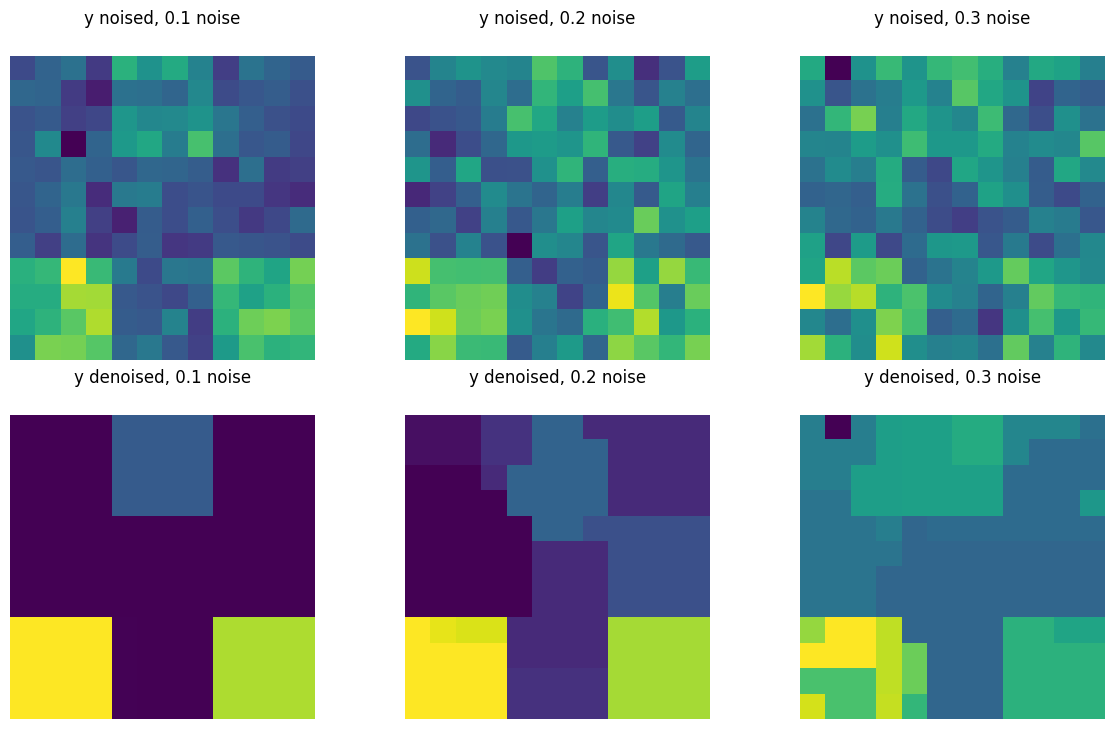

In [ ]:
np.random.seed(12)

o_dim = 3
scale = 4

y_original = np.random.binomial(1, 0.3, o_dim * o_dim).reshape(o_dim, o_dim) * \
            np.random.uniform(0, 1, (o_dim, o_dim)).round(2)
y_original = y_original.repeat(scale, axis=0).repeat(scale, axis=1)

lambda_1 = 0.02
lambda_2 = 0.15
noise_list = [0.1, 0.2, 0.3]

fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for idx, noise in enumerate(noise_list):
    y = y_original + np.random.normal(0, noise, y_original.shape)

    ax = axs[0, idx]
    ax.matshow(y)
    ax.set_title(f"y noised, {noise} noise")
    ax.axis('off')
    
    model = FLSA_2D(lambda_1=lambda_1, lambda_2=lambda_2, max_iter=10).fit(y)
    ax = axs[1, idx]
    ax.matshow(model.coef_)
    ax.set_title(f"y denoised, {noise} noise")
    ax.axis('off')

# plt.suptitle("Denoised outputs with varying noise", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("images/denoising_noise_comparison_3.png")
plt.show()


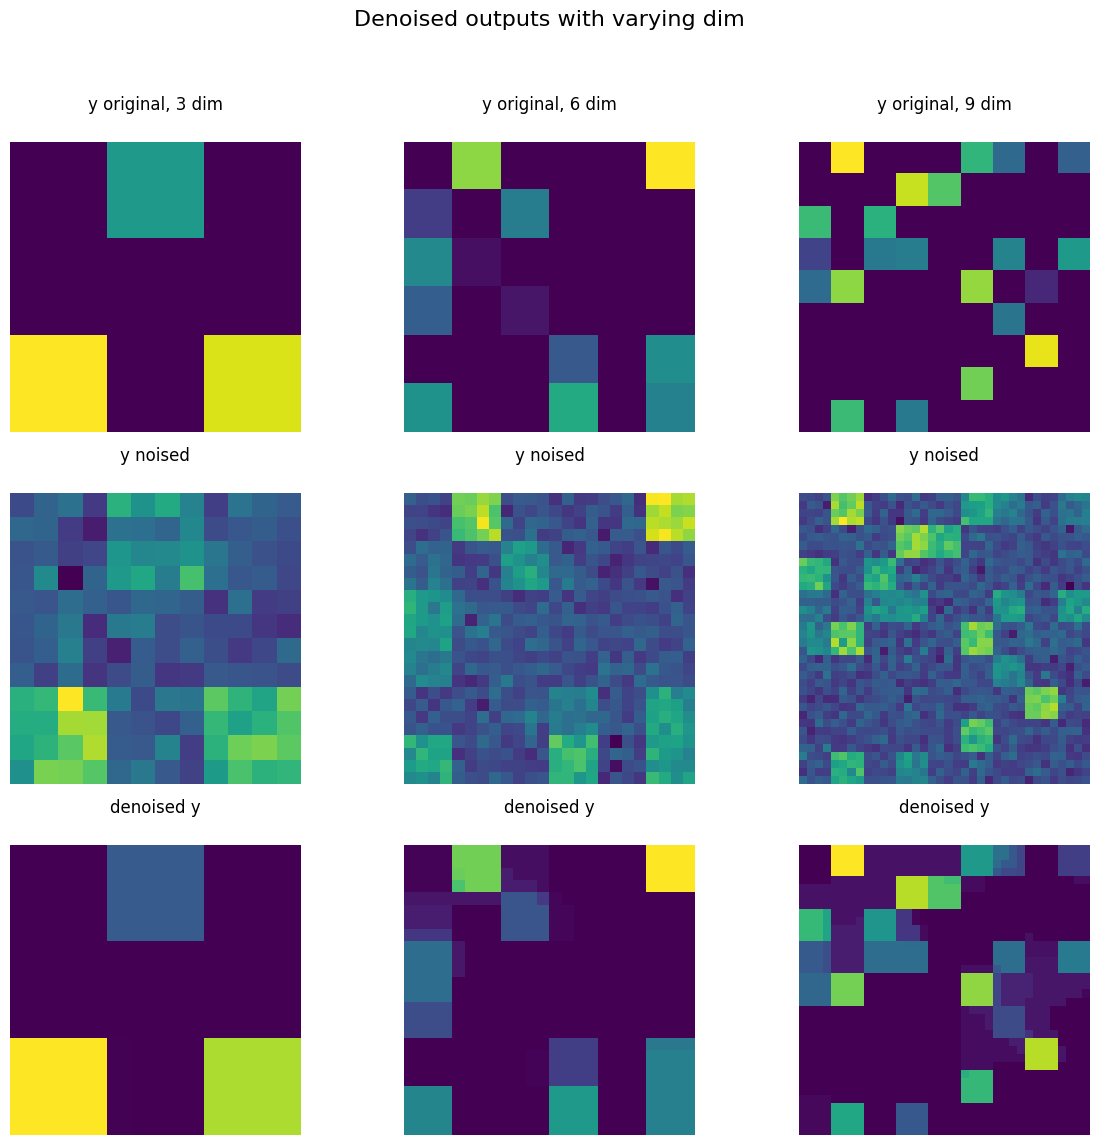

In [ ]:
lambda_1 = 0.02
lambda_2 = 0.15
dim_list = [3, 6, 9]

fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for i in range(3):
    for j, dim in enumerate(dim_list):
        np.random.seed(12)

        o_dim = dim
        scale = 4

        y_original = np.random.binomial(1, 0.3, o_dim * o_dim).reshape(o_dim, o_dim) * \
                    np.random.uniform(0, 1, (o_dim, o_dim)).round(2)
        y_original = y_original.repeat(scale, axis=0).repeat(scale, axis=1)
        y = y_original + np.random.normal(0, 0.1, y_original.shape)

        model = FLSA_2D(lambda_1=lambda_1, lambda_2=lambda_2, max_iter=10).fit(y)
        ax = axs[i, j]
        if i == 0: 
            ax.matshow(y_original)
            ax.set_title(f"y original, {dim} dim")
            ax.axis('off')
        elif i == 1: 
            ax.matshow(y)
            ax.set_title("y noised")
            ax.axis('off')
        else:
            ax.matshow(model.coef_)
            ax.set_title("denoised y")
            ax.axis('off')

    

# plt.suptitle("Denoised outputs with varying dim", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("images/denoising_dim_comparison_4.png")
plt.show()

# 76 min

### EXAMPLES NOT IN REPORT

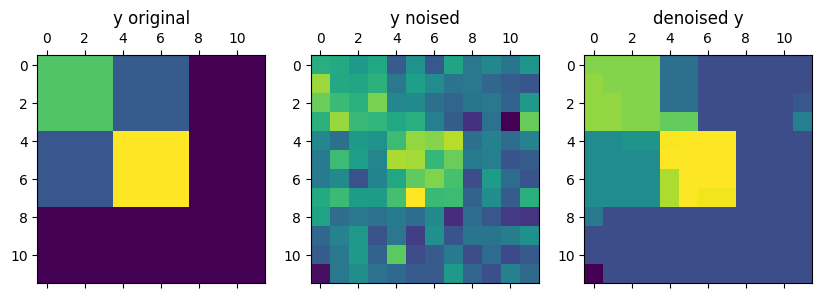

In [ ]:
o_dim = 3
scale = 4

y_original = np.random.binomial(1, 0.3, o_dim * o_dim).reshape(o_dim, o_dim) * np.random.uniform(0, 1, (o_dim, o_dim)).round(2)
y_original = y_original.repeat(scale, axis=0).repeat(scale, axis=1)
y = y_original + np.random.normal(0, 0.1, y_original.shape)

lambda_1 = 0.12
lambda_2 = 0.15
model = FLSA_2D(lambda_1=lambda_1, lambda_2=lambda_2).fit(y)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
ax[0].matshow(y_original)
ax[0].set_title("y original")
ax[1].matshow(y)
ax[1].set_title("y noised")
ax[2].matshow(model.coef_)
ax[2].set_title("denoised y")
plt.show()

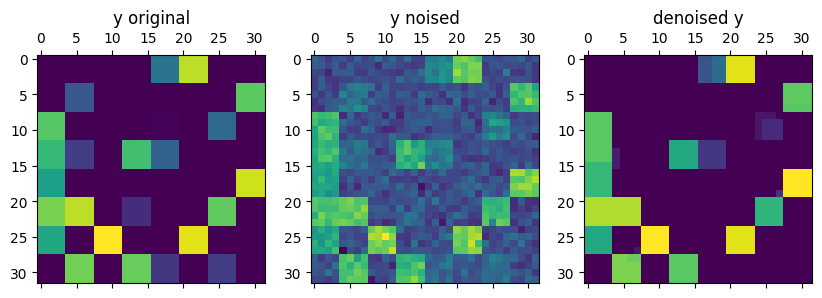

In [45]:
o_dim = 8
scale = 4

y_original = np.random.binomial(1, 0.3, o_dim * o_dim).reshape(o_dim, o_dim) * np.random.uniform(0, 1, (o_dim, o_dim)).round(2)
y_original = y_original.repeat(scale, axis=0).repeat(scale, axis=1)
y = y_original + np.random.normal(0, 0.1, y_original.shape)

lambda_1 = 0.12
lambda_2 = 0.15
model = FLSA_2D(lambda_1=lambda_1, lambda_2=lambda_2).fit(y)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
ax[0].matshow(y_original)
ax[0].set_title("y original")
ax[1].matshow(y)
ax[1].set_title("y noised")
ax[2].matshow(model.coef_)
ax[2].set_title("denoised y")
plt.show()

In [7]:
y = pd.read_csv("c/data/y.csv", header=None).values

In [8]:
start = time.time()
model = FLSA_2D(lambda_1=0.12, lambda_2=0.15).fit(y)
end = time.time()

In [9]:
print(f"evaluation took {prettifyDurationInSeconds(end - start)}")

evaluation took 6.0h 13.0m 45.633788108825684s


In [10]:
pd.DataFrame(model.coef_).to_csv("c/data/gamma_python.csv", header=False, index=False)